# MovieLens Data Analysis

Performs the data analysis and preprocessing of the MovieLens 32M dataset (239MB, https://grouplens.org/datasets/movielens/32m/).

The dataset contains 32M movie ratings from 0.5 - 5.0 stars from about 200,000 users applied to about 90,000 movies. The users were randomly selected for this dataset but were required to had rated at least 20 movies. We will focus on the ratings.csv which contains the user and movie IDs, along with the ratings. 

In [1]:
from os.path import abspath, join
import pandas as pd
import numpy as np
import torch as pt

np.random.seed(42)

DATASET = "ml-32m"
DATA_PATH_RAW = join('.', 'data', "raw", DATASET)
DATA_PATH_PRE = join('.', 'data', "preprocessed", DATASET)

## Data loading and analysis

In [2]:
# Load the ratings data including userId, movieId and rating
df = pd.read_csv(join(DATA_PATH_RAW, "ratings.csv"))
df.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [3]:
print("Number of unique user IDs:       ", df["userId"].nunique())
print("Number of unique movie IDs:      ", df["movieId"].nunique())
print("Total number of ratings:         ", round(len(df) / 1e6, 2), "million")

Number of unique user IDs:        200948
Number of unique movie IDs:       84432
Total number of ratings:          32.0 million


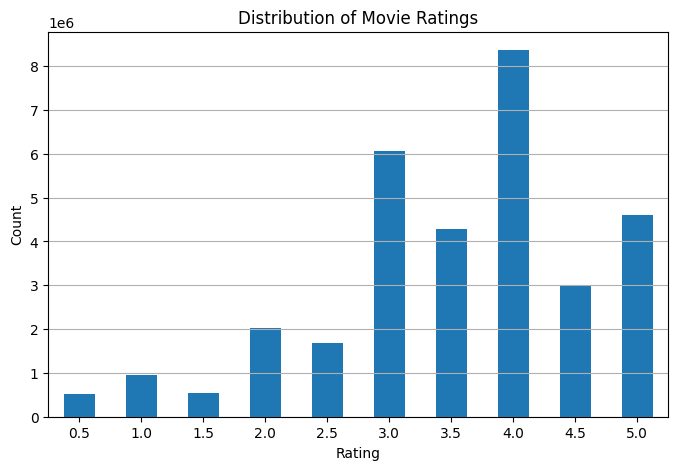

In [4]:
# Let's plot the distribution of ratings
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

This shows that splitting at a rating of 4.0 stars is a sensible choice and has a reasonable signal.

In [5]:
df

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858
...,...,...,...,...
32000199,200948,79702,4.5,1294412589
32000200,200948,79796,1.0,1287216292
32000201,200948,80350,0.5,1294412671
32000202,200948,80463,3.5,1350423800


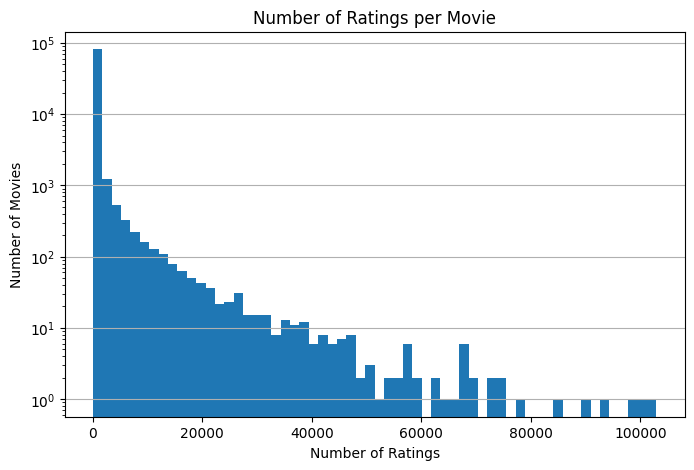

In [6]:
# Let's plot the number of ratings per movie
ratings_per_movie = df.groupby('movieId').size()
plt.figure(figsize=(8, 5))
plt.hist(ratings_per_movie, bins=60, log=True)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.grid(axis='y')
plt.show()

This distribution shows the classical long tail with most movies having as little as 1 rating up to several movies which have over 80k ratings. We can find out what these movies are by looking in the movies.csv

In [18]:
# Load movie names and genres
movie_names = pd.read_csv(join(DATA_PATH_RAW, "movies.csv"))
movie_names.head()

# sort and show top 5 movies with most ratings
ratings_per_movie.sort_values(ascending=False, inplace=True)

# get their names
top_5_movies = movie_names[movie_names['movieId'].isin(ratings_per_movie.index[:5])]
print("Top 5 movies with most ratings:")
print(top_5_movies["title"])

Top 5 movies with most ratings:
292                  Pulp Fiction (1994)
314     Shawshank Redemption, The (1994)
351                  Forrest Gump (1994)
585     Silence of the Lambs, The (1991)
2480                  Matrix, The (1999)
Name: title, dtype: object


## Data Processing: Explicit to Implicit 

To simulate an implicit feedback, the rating is converted to a binary format. Right now the user-item matrix consists of either missing values or ratings from 0.5 to 5.0 stars. 

To get to a binary format, we convert:
- rating 4.0 or higher --> 1: the user actively clicked on this movie (interest) 
- rating below 4.0 or no rating --> 0: the user ignored

This will give us:
- 1: positive signal
- 0: no signal because of dislike, because never been exposed to this movie, never clicked on this movie, ...

In [75]:
# keep only positive implicit feedback (ratings >= 4.0)
print("# Rows before filtering: ", round(len(df) / 1e6, 2), "million")
df = df[df['rating'] >= 4.0]
print("# Rows after filtering: ", round(len(df) / 1e6, 2), "million")

df.drop(columns=['rating'], inplace=True)
df.head()

# Rows before filtering:  32.0 million
# Rows after filtering:  15.94 million


,userId,movieId,timestamp
0,1,17,944249077
3,1,30,944249077
4,1,32,943228858
7,1,80,944248943
9,1,111,944249008


In [76]:
# split into train and test
# for that we need we need to sort by user-timestamp so that 80% of each user's interactions go to train and 20% to test

# sort chronologically per user
df = df.sort_values(['userId', 'timestamp'])

def split_data(df, test_frac=0.2, drop_threshold: int=None):
    """Splits the data into train and test sets per user."""
    
    # function to split each user's interactions into train and test
    def split_user(group, test_frac=0.2):
        n = len(group)
        split = int((1 - test_frac) * n)
        return group.iloc[:split], group.iloc[split:]

    # empty lists to hold train and test parts
    train_parts = []
    test_parts = []

    # iterate over each user and split their interactions into train and test
    for _, group in df.groupby("userId"):
        # optional: drop ultra-sparse users
        if drop_threshold is not None and len(group) < drop_threshold:
            continue
        train, test = split_user(group, test_frac=test_frac)
        train_parts.append(train)
        test_parts.append(test)

    # concatenate all parts to get final train and test DataFrames
    train_df = pd.concat(train_parts)
    test_df  = pd.concat(test_parts)
    return train_df, test_df

# create train and test splits, dropping users with less than 5 interactions
train_df, test_df = split_data(df, test_frac=0.2, drop_threshold=5)

# Sanity check split
print("Train/test split:                ", round(len(train_df) / len(df), 3), "/", round(len(test_df) / len(df), 3))
print("Number of interactions in train: ", len(train_df))
print("Number of interactions in test:  ", len(test_df))

Train/test split:                 0.795 / 0.205
Number of interactions in train:  12666859
Number of interactions in test:   3266277


In [77]:
# Reindex users and movies by embedding their IDs from 0 to num_users-1 continuously
all_user_ids = pd.concat([train_df["userId"], test_df["userId"]]).unique()
all_item_ids = pd.concat([train_df["movieId"], test_df["movieId"]]).unique()

user2idx = {u: i for i, u in enumerate(all_user_ids)}
item2idx = {m: i for i, m in enumerate(all_item_ids)}

for df in [train_df, test_df]:
    df["u"] = df["userId"].map(user2idx)
    df["i"] = df["movieId"].map(item2idx)

# this is the result
print("Train: \n", train_df.head(), "\n")
print("Test: \n", test_df.head())

Train: 
      userId  movieId  timestamp  u  i
137       1     2997  943226846  0  0
131       1     2890  943226916  0  1
23        1      541  943227521  0  2
30        1      838  943227632  0  3
69        1     1236  943228400  0  4 

Test: 
      userId  movieId  timestamp  u     i
36        1      923  944250228  0   724
52        1     1183  944250228  0  1412
122       1     2520  944250228  0  2109
41        1     1041  944253134  0  1573
86        1     1693  944253134  0  2012


In [78]:
# now we create the sparse tensor with torch in the COO format ( Coordinate List )
# instead of dense tensor to save memory, the sparse tensor only stores the indices (row, col) and values of non-zero elements
num_users = len(user2idx)
num_items = len(item2idx)

def create_sparse_tensor(df, num_users, num_items):
    # 1) create tensor of user-item matrix indices
    indices = pt.tensor(
        [df["u"].values, df["i"].values],
        dtype=pt.long
    )
    # should be (2, num_interactions)
    # first dim is user indices, second dim is item indices
    print("Shape (2, num_interactions):", "\n       ", indices.shape)
    print("First 5 interaction indices:", "\n       ", indices[:, :5])

    # 2) create tensor of values (all ones for implicit feedback)
    values = pt.ones(len(df), dtype=pt.float32)

    # 3) create the sparse tensor
    X = pt.sparse_coo_tensor(
        indices=indices,
        values=values,
        size=(num_users, num_items)
    )
    print("Shape (n_users, n_items):", "\n       ", X.shape, "\n")

    # not required here, but good practice to coalesce sparse tensors
    # remove duplicate entries and sort indices
    X = X.coalesce()  
    return X

In [79]:
# create sparse tensors for train and test sets
X_train = create_sparse_tensor(train_df, num_users, num_items)
X_test  = create_sparse_tensor(test_df, num_users, num_items)

Shape (2, num_interactions): 
        torch.Size([2, 12666859])
First 5 interaction indices: 
        tensor([[0, 0, 0, 0, 0],
        [0, 1, 2, 3, 4]])
Shape (n_users, n_items): 
        torch.Size([198979, 55173]) 

Shape (2, num_interactions): 
        torch.Size([2, 3266277])
First 5 interaction indices: 
        tensor([[   0,    0,    0,    0,    0],
        [ 724, 1412, 2109, 1573, 2012]])
Shape (n_users, n_items): 
        torch.Size([198979, 55173]) 



In [80]:
# save preprocessed data
pt.save(X_train, abspath(join(DATA_PATH_PRE, "X_train.pt")))
pt.save(X_test, abspath(join(DATA_PATH_PRE, "X_test.pt")))